# Promocode campaign

A french taxicab company launched a marketing campaign in May 2017. This campaign consisted in releasing a promocode to boost the loyalty points gained during a ride. To be eligible to promocode, a user must satisfy 3 criteria:
1. The ride is during promo period (May, 17-21th).
2. The user claimed the promocode.
3. The user gained loyalty points during the ride.

Throughout this notebook, I am going to analyse the data collected during promocode and answer the question: Was the promocode campaign successful? In particular, 2 aspects will be covered: Was there a significant increase in the number of rides performed during this campaign? Were the gains generated by promocode high enough to cover the cost of the campaign? In this regard, I will come up with a data-driven startegy that will make this marketing campaign profitable for the company while being beneficial for users.

There are 2 datasets to study in this notebook: 
1. events.csv for promotion and discount events.
2. rides.csv stores information about the rides and users.

Before starting, let's import some useful packages:

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

To center ths plots in this notebook, we run the following cell:

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## 1. Data ingestion & exploration

Let's start by reading events and rides datasets:

In [3]:
events = pd.read_csv(r'data/events.csv',delimiter=',')
rides = pd.read_csv(r'data/rides.csv',delimiter=',')

events.shape, rides.shape

((292309, 5), (1445664, 11))

The events and rides tables contain respectively 292309 and 1445664 rows.

### events

Let's explore the events table:

In [4]:
events.head(5)

,event_id,ride_id,type,user_id,promocode_name
0,457113065c424d25eff17823ad888162,NaN,other_coupon_action,c045abae8a3110ea6cec54b2f49f9f2d,89f13478125cee693ce7f76fedf01808
1,06e5ceb932743b583dc4349f617d1fde,NaN,coupon_created,c33cc932b7a4feb6f51d7ed1077faa05,8041613eff4408b9268b66430cf5d9a1
2,f08b5f110a9e2e9c3eac3f03e8ad801b,NaN,coupon_created,da03b00f7dd32fa31b800ecb762ef1df,308dd493382b32ebf486da92fdeaf38d
3,4265bc09df57f4fb6991f832b24e643c,NaN,coupon_created,0928a1d559774b05be5e6926920d2873,c4afe8e1914a1f612ca82d59ec72c771
4,4a5d1f58698acb12ca4da6b24535693d,NaN,coupon_created,960025162805d2c5942334c5ed200528,308dd493382b32ebf486da92fdeaf38d


There 2 types of events. The one that corresponds to promocode is coupon_created. The column ride_id is sometimes empty for either types.

Some basic statistics about the features:

In [5]:
events.describe(include = ['O'])

,event_id,ride_id,type,user_id,promocode_name
count,292309,102431,292309,292309,292309
unique,292309,101754,2,74335,4350
top,92df3b058bb1631952b2b7e0c36d01ca,ec84dfda8fd30912da8dd4b24eddad9b,coupon_created,6879c8222c55a5f13e0841999ce604ad,9a03c798c04a6839996c26c8d34fa835
freq,1,4,172175,137,66938


The number of users is far inferior from the number of events. An average user is likely to claim many promotion and discount events. Now, does the users claim only one type of events? The answer may be obvious, but we need to check it out:

In [6]:
type1_users = events[events.type=='coupon_created'].user_id.unique()
type2_users = events[events.type!='coupon_created'].user_id.unique()
both_types_users = list(set(type1_users).intersection(type2_users))
print ('Number of users who claimed both types of events: %d'%len(both_types_users))

Number of users who claimed both types of events: 53008


Now, let's check the distribution of events types:

In [7]:
events.type.value_counts()

coupon_created         172175
other_coupon_action    120134
Name: type, dtype: int64

In [8]:
print ('{} claims for promocode'.format(events.type.value_counts()['coupon_created']))

172175 claims for promocode


For the needs of this study, we need to determine the users who claimed promocode:

In [9]:
#Users who claimed promocode
promocode_users = events[events.type == 'coupon_created']
promocode_users.drop(['event_id','ride_id','promocode_name'], inplace=True, axis=1)
promocode_users.drop_duplicates(inplace=True)
num_promocode_claims = promocode_users.shape[0]
print ('{} of users claiming for promocode'.format(num_promocode_claims)) 

74335 of users claiming for promocode


### rides

Let's move on to rides table:

In [10]:
rides.head()

,ride_id,user_id,loyalty.status,booking_id,isGuest,loyalty_points_earned,price.loyalty.points_spent,price_nominal,price_after_discount,state,quote_date
0,357a545ef665da69dd86ac33ae817f3a,c6f3a631ae33a84c343dd9c553889337,1,1ea36f95a86a5a876456ce66587f4882,False,0,NaN,5.48,5.80,not_completed,2017-03-01 11:07:49
1,5714536c4b4b1b10c4cd8ac907537044,0bad5fc7936b072d8de8749b9dd608c6,1,NaN,False,0,NaN,4.72,4.72,not_completed,2017-03-02 22:45:02
2,5c8f5dec570b6597090f8b30ea33b0af,0bad5fc7936b072d8de8749b9dd608c6,1,NaN,False,5,NaN,4.72,4.72,completed,2017-03-02 22:45:22
3,0f37be24f23a15746eb8774e7a1bd934,37169a3d6636e14afabb1dbe01f5c83e,0,NaN,False,8,NaN,7.68,7.68,completed,2017-03-03 00:22:45
4,67f054abb8b60132dd7c19cb30e74e10,b89d8219faa82966c7b33ee69b484ad2,3,NaN,False,7,NaN,4.00,4.00,completed,2017-03-04 03:32:15


This table is heavier than events table. It contains 11 features. Among these features, there is user_id and ride_id that can be found in events tables.
Let's describe numerical and categorical features:

In [11]:
rides.describe()

,loyalty.status,loyalty_points_earned,price_nominal,price_after_discount
count,1.445664e+06,1.445664e+06,1.445664e+06,1.445664e+06
mean,1.389330e+00,6.166378e+00,6.067424e+00,5.842311e+00
std,1.105604e+00,4.287580e+00,1.948661e+00,2.165742e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.000000e+00,4.580000e+00,4.430000e+00
50%,1.000000e+00,7.000000e+00,5.560000e+00,5.480000e+00
75%,2.000000e+00,9.000000e+00,7.070000e+00,6.960000e+00
max,3.000000e+00,5.900000e+01,2.207500e+02,2.207500e+02


In [12]:
rides.describe(include=['O'])

,ride_id,user_id,booking_id,price.loyalty.points_spent,state,quote_date
count,1445664,1445664,150869,9531,1445664,1445664
unique,1445664,180692,138200,30,2,1174830
top,acb7444240f8c293547092d15e3f7474,113ce40a23019538afe496eb21df2cd7,efc76d74cafa28bc9c42d6946d7ae013,"1,000",completed,2017-04-03 05:32:45
freq,1,2898,49,7909,1156808,50


price.loyalty.points_spent is considered as categorical feature because of the presence of "," in some numbers. Here, the column is transformed to a numerical one:

In [13]:
rides['price.loyalty.points_spent'] = rides['price.loyalty.points_spent'].apply(lambda x:str(x).replace(',','.')).astype(float)
print('done')

done


In this section, some questions regarding business rules will be addressed: Does a guest earn loyalty points? Can we spend bonus points and gain some in the same ride? Can we gain bonus points in a not completed ride?

In [14]:
print ('Number of rides where guests earn bonus points:',
       rides[(rides['isGuest'])&(rides['loyalty_points_earned']>0)].shape[0])
print ('Number of rides where bonus points are spent and earned in the same ride:',
       rides[(rides['price.loyalty.points_spent']>0)&(rides['loyalty_points_earned']>0)].shape[0])
print ('Number of not completed rides where a user gain points:',
       rides[(rides['state']=='not_completed')&(rides['loyalty_points_earned']>0)].shape[0])

Number of rides where guests earn bonus points: 0
Number of rides where bonus points are spent and earned in the same ride: 942
Number of not completed rides where a user gain points: 12528


We need to determine the eligible rides, meaning those performed between 17th and 21th may and earned their users bonus points:

In [15]:
eligible_rides = rides[(rides['loyalty_points_earned']>0)
                       &(rides['quote_date']>='2017-05-17 00:00:00')
                       &(rides['quote_date']<'2017-05-22 00:00:00')
                       ]

num_payee_users = len(eligible_rides.user_id.unique())
print ('Number of users who gained bonus points: ',num_payee_users)

Number of users who gained bonus points:  39896


The conversion rate is defined as follow: number of people who gained bonus loyalty points over number of people who claimed the promocode.

In [16]:
conversion_rate = (num_payee_users / num_promocode_claims)*100
print('conversion_rate = %.2f'%conversion_rate+'%')

conversion_rate = 53.67%


## 2. Data Analysis & visualization

To get all rides that satisfy each of the promocode requirements, we need to make sure that the user in the eligible ride has claimed the promocode. For this, we need to merge the datesets eligible_rides and promocode_users.

A user may have many rides, which belong to 0, 1 or more than one promotion event. It is likely that a user has done 2 eligible rides and, in the same time, he has claimed promocode only once. To determine if a ride belongs to promocode, we need to know both user_id and ride_id keys, which is not possible in this case. So, the merge operation will be done only using user_id key. Doing so, some rides will be wrongly considered as part of promocode campaign. In the former example, the ride in which the user did not claim. The true number of promocode rides is only a subset of the dataset resulting from merge operation. Having no other way to identify this subset, we assume the 2 sets to be identical.

In [17]:
promocode_rides = eligible_rides.merge(promocode_users,on='user_id',how='inner')
num_promocode_rides = promocode_rides.shape[0]
print ('Number of rides made with promocode: ',num_promocode_rides)

Number of rides made with promocode:  22570


Before delving into data analysis, we need to construct the subset of rides that does not hold promocode rides (rides - pormocode_rides). We call this subset other_rides. The union of promocode_rides and other_rides must yield the total rides.

In [18]:
promocode_rides.drop('type', inplace = True, axis = 1)
promocode_rides['date'] = promocode_rides['quote_date'].map(lambda x:''.join(x[:10]))
rides['date'] = rides['quote_date'].map(lambda x:''.join(x[:10]))
other_rides = rides[(~rides.ride_id.isin(promocode_rides.ride_id))]
assert(other_rides.shape[0] == rides.shape[0], promocode_rides.shape[0])

### Rides by loyalty status

Below a plot of the proportion of rides done by each loyalty status:

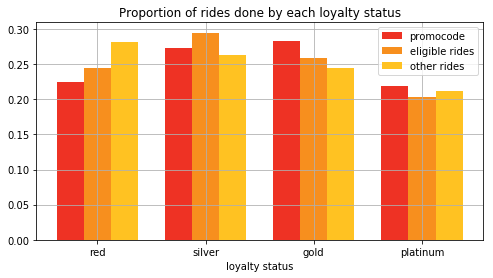

In [19]:
def column_distribution(df,column):
    """This function is used to compute number of rides scaled to the range (0,1) 
    per column category in the dataframe df
    
    --Arguments:
    df: pandas dataframe
    column: string"""
    
    column_df = df[[column,'ride_id']]
    column_df.rename(columns={'ride_id':'rides'},inplace=True)
    column_df['rides']=1
    rides_column = column_df.groupby([column], as_index=False).count()
    rides_column['rides'] = rides_column['rides']/column_df['rides'].shape[0]
    return rides_column

pos = list(range(len(rides['loyalty.status'].unique())))
width = 0.25
colors = ['#EE3224','#F78F1E','#FFC222']
labels = ['promocode','eligible rides','other rides']
dataframes =[promocode_rides,eligible_rides,other_rides]

fig, ax = plt.subplots(figsize=(8, 4))
for i,df in enumerate(dataframes):
    loyalty_df = column_distribution(df,'loyalty.status')
    ax.bar([p + i*width for p in pos]
           ,loyalty_df['rides']
           ,width
           ,color=colors[i]
           ,label=labels[i]
           ,align='center')

ax.set_xticks([p + width for p in pos])
ax.set_xticklabels(['red','silver','gold','platinum'])
ax.set_xlabel('loyalty status')
ax.set_title("Proportion of rides done by each loyalty status")
plt.legend()
plt.grid()
plt.show()

The more the user is engaged, the more likely he is interested by the promocode campaign relatively to an average user.

### Number of rides

In this section, we will see if the number of rides has increased during promocode campaign.

Let's first see how many rides are done during the campaign:

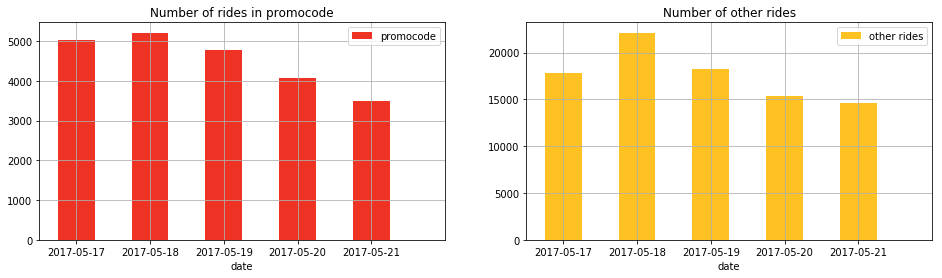

In [20]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.hist(promocode_rides['date']
         ,bins = np.arange(6)
         ,width = .5
         ,color = '#EE3224'
         ,label = 'promocode')
ax1.set_xlabel('date')
ax1.set_xticks(np.arange(5)+width)
ax1.set_title('Number of rides in promocode')
ax1.legend(loc="best")
ax1.grid(True)

ax2.hist(other_rides[(other_rides['date']>='2017-05-17')&(other_rides['date']<'2017-05-22')]['date']
         ,bins = np.arange(6)
         ,width = .5
         ,color = '#FFC222'
         ,label = 'other rides')

ax2.set_xlabel('date')
ax2.set_xticks(np.arange(5)+width)
ax2.set_title('Number of other rides')
ax2.legend(loc="best")
ax2.grid(True)          

plt.show()

The number of rides done during the campaign reaches its peak on May 18th and starts decreasing the day after. This behaviour is not specific to promocode rides as a similar pattern is observed in other rides. However, to get the full picture, we need to observe this number in a much larger time window.

In the following section, we will plot the number of rides, number of users and revenues generated in the period in which the data was collected (March - May). Each plot is produced by stacking the data from promocode_rides and other_rides, so that the resulting data corresponds to the overall rides. However, this is not true for the number of users, since there might exist users who have done a promocode ride and non-eligible ride in the same day. such users would be counted twice. So, in this particular case, a third plot is added to the figure for the overall rides.

First, we define some functions useful to the plots:

In [21]:
def rides_by_days(df):
    """This function returns a dataset containing the number of rides per day
    
    --Arguments:
    df: pandas dataframe"""
    
    rides_df = df[['date','ride_id']]
    rides_df.rename(columns={'ride_id': 'rides'}, inplace=True)
    rides_df['rides']=1
    
    return rides_df.groupby(['date'], as_index=False).count()

def revenues_by_days(df):
    """This function returns a dataset containing the revenues per day
    
    --Arguments:
    df: pandas dataframe"""
    
    rides_df = df[['date','price_after_discount']]
    rides_df.rename(columns={'price_after_discount': 'revenue'}, inplace=True)
    
    return rides_df.groupby(['date'], as_index=False).sum()

def num_users(df,date):
    """This function returns the number of users who have taken rides before (and during) the date passed as argument.
    
    --Arguments:
    df: pandas dataframe
    date: string with format yyyy-mm-dd"""
    
    return len(df[(df['date'] <= date)].user_id.unique())

def users_by_days(df):
    """This function returns a dataset containing number of users per day
    
    --Arguments:
    df: pandas dataframe"""
    
    users_date = df[['date','user_id']].sort_values(by='date',ascending=True)
    num_users = [len(users_date[users_date['date'] == d].user_id.unique()) for d in list(users_date.date.unique())]
    users_date.drop('user_id',inplace=True,axis=1)
    users_date.drop_duplicates(inplace=True)
    users_date['users'] = num_users
    
    return users_date

Now we plot the graphs:

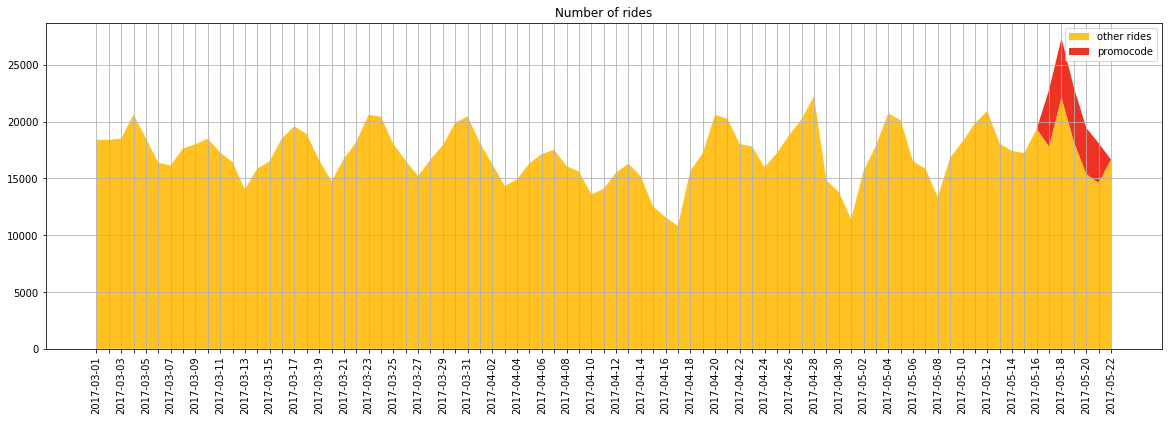

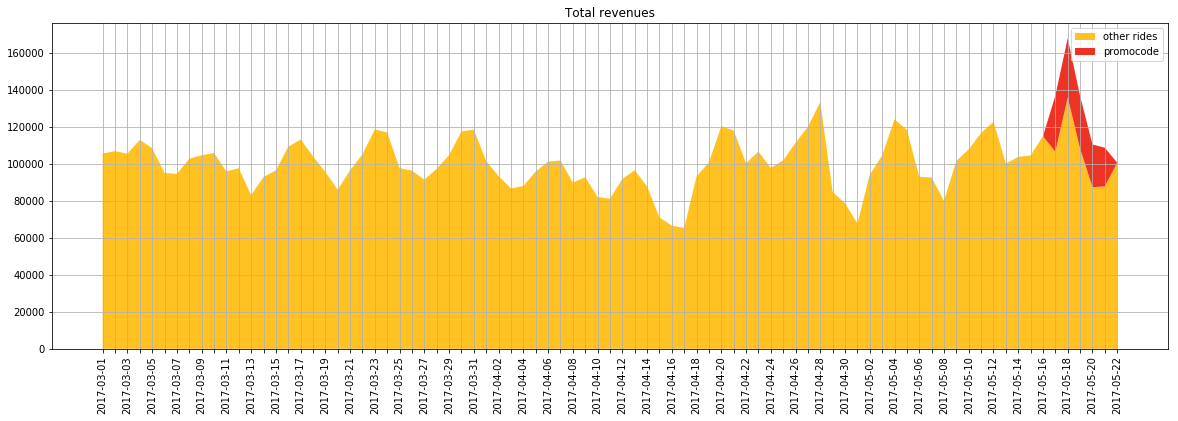

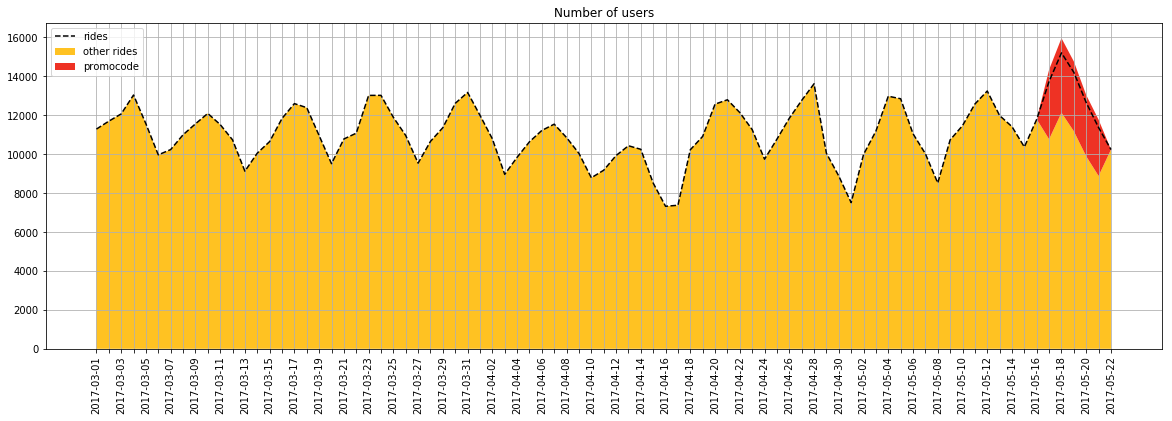

In [22]:
day1 = '2017-03-01'

##Number of rides
fig1 = plt.figure(figsize=(20,6))
ax1 = fig1.add_subplot(111)

promocode_rides_days, other_rides_days = (rides_by_days(promocode_rides)
                                          ,rides_by_days(other_rides[(other_rides['date']>=day1)]))

rides_days = other_rides_days.merge(promocode_rides_days,on='date',how='left')
rides_days.fillna(0,inplace=True)

ax1.stackplot(rides_days['date'],rides_days['rides_x'],rides_days['rides_y']
        ,colors = ['#FFC222','#EE3224']
        ,labels = ['other rides','promocode'])


ax1.set_title('Number of rides')
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

xticks1 = ax1.xaxis.get_major_ticks()
for i in range(len(xticks1)):
    if i%2 !=0:
        xticks1[i].label1.set_visible(False)
        
plt.legend()
plt.grid()

##Total revenues    
fig2 = plt.figure(figsize=(20,6))
ax2 = fig2.add_subplot(111)

promocode_revenues_days, other_revenues_days = (revenues_by_days(promocode_rides)
                                                ,revenues_by_days(other_rides[(other_rides['date']>=day1)]))

revenues_days = other_revenues_days.merge(promocode_revenues_days,on='date',how='left')
revenues_days.fillna(0,inplace=True)

ax2.stackplot(revenues_days['date'],revenues_days['revenue_x'],revenues_days['revenue_y']
        ,colors = ['#FFC222','#EE3224']
        ,labels = ['other rides','promocode'])


ax2.set_title('Total revenues')
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

xticks2 = ax2.xaxis.get_major_ticks()
for i in range(len(xticks2)):
    if i%2 !=0:
        xticks2[i].label1.set_visible(False)
    
plt.legend()
plt.grid()

##Number of users
fig3 = plt.figure(figsize=(20,6))
ax3 = fig3.add_subplot(111)

promocode_users_days, other_users_days = (users_by_days(promocode_rides)
                                          ,users_by_days(other_rides[(other_rides['date']>=day1)]))

users_days = other_users_days.merge(promocode_users_days,on='date',how='left')
users_days.fillna(0,inplace=True)

rides_users_days = users_by_days(rides[(rides['date']>=day1)])

ax3.stackplot(users_days['date'],users_days['users_x'],users_days['users_y']
        ,colors = ['#FFC222','#EE3224']
        ,labels = ['other rides','promocode'])

ax3.plot(rides_users_days['date'],rides_users_days['users'],'--',label='rides',color='black')


ax3.set_title('Number of users')
for tick in ax3.get_xticklabels():
    tick.set_rotation(90)
    
xticks3 = ax3.xaxis.get_major_ticks()
for i in range(len(xticks3)):
    if i%2 !=0:
        xticks3[i].label1.set_visible(False)
    
plt.legend()
plt.grid()

plt.show()

Here are a few findings:
- Clearly, there is a significant increase in the number of rides done during the period 17-20th of May. In particular, the peak is reached on 2017-05-18, the day after the promocode campaign was lauched.
- There is a bigger increase in the number of users in terms of magnitude. Thus, users tend to do less rides using promocode than the normal.
- Although there is a significant increase in the revenues generated during the campaign, an average user spends less money in promocode rides. This may be related to the small number of rides he performs in promocode.

In the following part, we will check if theses assumptions are true. 

### Revenues per ride

In this section, we will try to know if there is a difference between the amount of money an average user spends in promocode and in other rides.

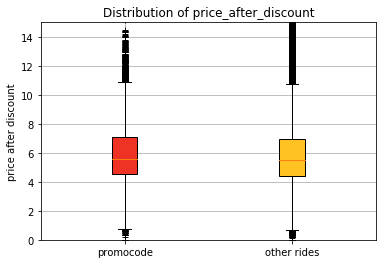

In [23]:
discounted_prices = [promocode_rides['price_after_discount'],
                     other_rides['price_after_discount']]

#boxplot
fig,ax = plt.subplots(figsize=(6,4))
bplot = ax.boxplot(discounted_prices, labels = ['promocode','other rides'], sym = '+',vert = True, patch_artist = True)
colors = ['#EE3224','#FFC222']
for patch,color in zip(bplot['boxes'],colors):
    patch.set_facecolor(color)
ax.set_ylabel('price after discount')
ax.set_ylim(0, 15)
ax.set_title('Distribution of price_after_discount')
plt.grid()
plt.show()

No significant difference in the price distribution between the 2 sets.

### Revenues per user

How much money an average user spends in a single ride during promocode campaign?

In [24]:
def revenue_per_user(df):
    """This function returns the revenues generated by an average user"""
    
    return df['price_after_discount'].sum()/len(df.user_id.unique())

print ('promocode users: %.2f€'%revenue_per_user(promocode_rides))
print ('others: %.2f€'%revenue_per_user(other_rides[(other_rides['date']>='2017-05-17')
                                                    &(other_rides['date']<'2017-05-22')]))

promocode users: 12.49€
others: 14.49€


### Number of rides per user

In this section, we will try to answer this question: Among the users who did rides during the promocode period, do the users tend to do less rides in promocode than the average? For this, we need to compare the distribution of number of rides between promocode and other rides.

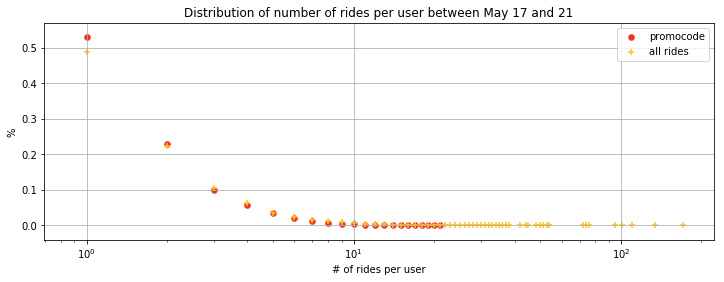

In [25]:
def rides_distribution(df):
    """This function computes the number of rides per user in the dataset df. 
    The resulting dataset contains a normalized distribution of these numbers
    
    --Arguments:
    df: pandas dataframe"""
    
    num_rides = df[['user_id','ride_id']].groupby(['user_id'], as_index=False).count()
    num_rides.drop('user_id',inplace=True, axis=1)
    num_rides.rename(columns={'ride_id': 'rides'}, inplace=True)
    num_rides['count'] = num_rides.groupby('rides')['rides'].transform('count')/num_rides.shape[0]
    num_rides.drop_duplicates(inplace=True)
    return num_rides

fig,ax = plt.subplots(figsize=(12,4))
promocode_rides_distr, all_rides_distr = (rides_distribution(promocode_rides)
                                          ,rides_distribution(rides[(rides['date']>='2017-05-17')
                                                                    &(rides['date']<'2017-05-22')]))
ax.scatter(promocode_rides_distr['rides'],promocode_rides_distr['count']
           ,marker = 'o'
           ,color = '#EE3224'
           ,linewidths  = .5
           ,label = 'promocode')
ax.scatter(all_rides_distr['rides'],all_rides_distr['count']
           ,marker = '+'
           ,color = '#FFC222'
           ,linewidths  = .5
           ,label = 'all rides')
ax.set_xscale('log')
ax.set_xlabel('# of rides per user')
ax.set_ylabel('%')
ax.set_title('Distribution of number of rides per user between May 17 and 21')
plt.legend()
plt.grid()
plt.show()

As expected, an average user do less rides in promocode.

In particular, more than 57% of users have done only 1 ride during the campaign. Whereas, this number falls under 50% in the general case.

We also notice that no user has done more than 21 rides in promocode. On the other hand, there exist users how have done more than 100 rides during the same period!

### Average number of rides per user

In this part, we try to determine the number of rides an average user does.

For this, we plot 2 graphs. In the first one, the average is calculated over the period defined by the first day and the current day. This is usefull to highlight some trends regarding the evlution of this average. In the second graph, the avergae is calculated on a daily basis. This allows us to observe the evolution of this average over a long period of time.

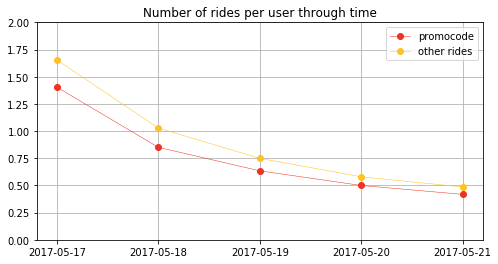

In [26]:
def rides_by_time(df):
    """This function computes the average number of rides per user.
    At a date d, this number is averaged over the period starting from the first date and ending to date d.
    
    --Arguments:
    df: pandas dataframe"""
    
    rides_df = df[['user_id','ride_id','date']]
    rides_df.rename(columns={'ride_id': 'rides'}, inplace=True)
    rides_df['rides']=1
    
    rides_date = rides_df[['date','rides']].groupby(['date'], as_index=False).count()
    cumul_rides = rides_date.rides.cumsum()
    rides_date['rides'] = cumul_rides
    
    users_date = rides_df[['date','user_id']].sort_values(by='date',ascending=True)
    users_cumul = [num_users(users_date,d) for d in list(users_date.date.unique())]
    users_date.drop('user_id',inplace=True,axis=1)
    users_date.drop_duplicates(inplace=True)
    users_date['users'] = users_cumul
    
    avg_rides = rides_date.merge(users_date,on='date',how='inner')
    avg_rides['rides'] /= avg_rides['users']
    avg_rides.drop('users',inplace=True,axis=1)
    
    min_day = pd.to_datetime(rides_df['date'].min()) 
    avg_rides['days'] = avg_rides['date'].map(lambda x: (pd.to_datetime(x) - min_day).days + 1)
    avg_rides['rides'] /= avg_rides['days']
    return avg_rides
    
fig,ax = plt.subplots(figsize=(8,4))

promocode_rides_time, other_rides_time = (rides_by_time(promocode_rides)
                                          ,rides_by_time(other_rides[(other_rides['date']>='2017-05-17')
                                                                    &(other_rides['date']<'2017-05-22')]))

ax.plot(promocode_rides_time['date'],promocode_rides_time['rides']
        ,'o-'
        ,color = '#EE3224'
        ,linewidth  = .5
        ,label = 'promocode')

ax.plot(other_rides_time['date'],other_rides_time['rides']
        ,'o-'
        ,color = '#FFC222'
        ,linewidth  = .5
        ,label = 'other rides')

ax.set_title('Number of rides per user through time')
ax.set_ylim(0,2)
plt.legend()
plt.grid()
plt.show()

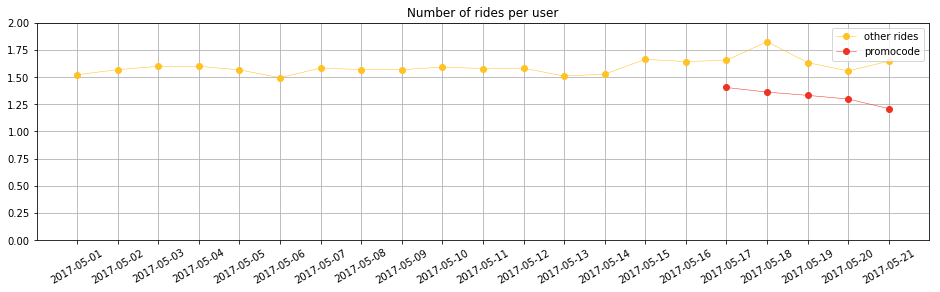

In [27]:
def rides_per_user(df):
    """This function returns the number of rides per user for each day
    
    --Arguments:
    df: pandas dataframe"""
    
    rides_df = df[['date','user_id','ride_id']]
    rides_df.rename(columns={'ride_id': 'rides'}, inplace=True)
    rides_df['rides']=1
    
    rides_date = rides_df[['date','rides']].groupby(['date'], as_index=False).count()
    
    users_date = rides_df[['date','user_id']].sort_values(by='date',ascending=True)
    num_users = [len(users_date[users_date['date'] == d].user_id.unique()) for d in list(users_date.date.unique())]
    users_date.drop('user_id',inplace=True,axis=1)
    users_date.drop_duplicates(inplace=True)
    users_date['users'] = num_users
    
    avg_rides = rides_date.merge(users_date,on='date',how='inner')
    avg_rides['rides'] /= avg_rides['users']
    avg_rides.drop('users',inplace=True,axis=1)
    
    return avg_rides

fig,ax = plt.subplots(figsize=(16,4))

promocode_rides_user, other_rides_user = (rides_per_user(promocode_rides)
                                          ,rides_per_user(other_rides[(other_rides['date']>='2017-05-01')
                                                                    &(other_rides['date']<'2017-05-22')]))

ax.plot(other_rides_user['date'],other_rides_user['rides']
        ,'o-'
        ,color = '#FFC222'
        ,linewidth  = .5
        ,label = 'other rides')
ax.plot(promocode_rides_user['date'],promocode_rides_user['rides']
        ,'o-'
        ,color = '#EE3224'
        ,linewidth  = .5
        ,label = 'promocode')

ax.set_title('Number of rides per user')
ax.set_ylim(0,2)
for tick in ax.get_xticklabels():
    tick.set_rotation(30)
plt.legend()
plt.grid()
plt.show()

- Promocode users have less rides than the general case in each day of the period
- In both cases, users tend to have less rides in the course of promocode campaign.

In the next part, we will try to determine the cost of this campaign, the revenues generated by the campaign and the profit/loss.


## 3. Cost, revenues and profit/loss

To calculate the revenues, we just sum over the prices paid by promocode users.

To calculate the cost, we assume that a bonus point is worth 0.1€

In [28]:
def promocode_revenue():
    """This function returns the revenues generated by promocode campaign"""
    
    global promocode_rides
    
    return promocode_rides['price_after_discount'].sum()
    
promocode_revenues = promocode_revenue()
print ('Revenues generated by promocode: %.2f€'%promocode_revenues)

Revenues generated by promocode: 134890.32€


In [29]:
bonus_cost = .1

def promocode_cost(bonus_multiplier=1):
    """This function returns the cost of promocode campaign
    
    --Arguments:
    bonus_multiplier: how many times bonus points are multiplied"""
    
    global promocode_rides
    
    return promocode_rides['loyalty_points_earned'].sum()*bonus_multiplier*bonus_cost

print ('Promocode campaign has the total cost: %.2f€'%promocode_cost())

Promocode campaign has the total cost: 19010.30€


We know that the company perceives only a small percentage of the price paid by the user.

Let p be this percentage, the gain (or loss) G is given by G = p * R - C

where R stands for Revenues and C for cost.

Below, an interactive graph where the user can choose the appropriate ratio (alse called commission) to be applied to revenues.

In [30]:
import ipywidgets as wg
from ipywidgets import Layout, Label
from IPython.display import display

def plot_cost_revenue(ratio,bonus):
    x = np.array(['cost','revenue','gain/loss'])
    y = np.array([-promocode_cost(bonus)
                  ,promocode_revenues
                  ,(ratio * promocode_revenues) - promocode_cost(bonus)]).astype(float)
    y = np.round_(y,decimals=2)
    color = np.array(['red','green','red' if y[2]<0 else 'green'])
    width=.5
    
    fig, ax = plt.subplots(figsize=(7, 6))

    ax.bar(list(range(3))
           ,y
           ,width
           ,color=color
           ,alpha=.5
           ,align='center')

    ax.set_xticks(list(range(3)))
    ax.set_xticklabels(x.tolist())
    ax.set_title("Cost vs Revenues (€)")
    ax.set_ylim(-100000,150000)
    
    for i, v in enumerate(y.tolist()):
        ax.text(i-0.2,v+2000,str(v), color='black', fontsize=12)
        
    plt.grid()
    plt.show()

ratio = wg.FloatSlider(value=.2,min=0.,max=1.,step=.01,description='ratio'
                       ,layout=Layout(width='58%',margin='0px 0px 0px 230px'))
bonus = wg.IntSlider(value=1,min=1,max=5,step=1,description='bonus multplier',style = {'description_width': 'initial'}
                          ,layout=Layout(width='58%',margin='0px 0px 0px 230px'))

if __name__ == '__main__':
    wg.interact(plot_cost_revenue,ratio=ratio,bonus=bonus)


A Jupyter Widget

Under the assumptions of this project and with a ratio of 20%, the campaign is profitable only when no bonus multiplier is applied. However, the goal of this campaign is to boost loyalty points gained by the users. Instead of multiplying the loyalty points by the same factor for all users, a more clever approach would be to link the bonus points allocation policy to loyalty status: the more loyal the user is, the more bonus points he gets. In addition, we may have to add some additional restrictions in order to be awarded: only completed rides paid totally or partially with real money - not with loyalty points. Moreover, we will set a minimum price to be paid by the user before he can earn bonus points. This price will be displayed as a parameter in the graph.

Before ploting the graph, below 2 functions used to compute the cost of the campaign following the newly defined rules.

In [31]:
def awarding_rides(min_price=0):
    """This function returns a dataset containg the rides satisfying the new rules
    
    --Arguments:
    min_price: the minimum price to be paid in order to be awarded additional points"""
    
    global promocode_rides
    
    promocode_rides['bonus'] = promocode_rides['loyalty.status'] + 2
    promocode_rides['bonus_points'] = promocode_rides['bonus'] * promocode_rides['loyalty_points_earned']
    awarding_rides = promocode_rides[(np.isnan(promocode_rides['price.loyalty.points_spent']))
                                     &(promocode_rides['price_after_discount'] >= min_price)
                                     &(promocode_rides['state']=='completed')]
    
    return awarding_rides

def final_cost(min_price=0):
    """This function calulates the cost of promocode campaign following the new rules
    
    --Arguments:
    min_price: the minimum price to be paid in order to be awarded additional points"""
    
    bonus_rides = awarding_rides(min_price)
    
    return bonus_rides['bonus_points'].sum() * bonus_cost
    
cost = final_cost()
print ('the cost of this campaign under the new rules: %.2f€'%cost)

the cost of this campaign under the new rules: 69319.50€


Now let's see how we can make this campaign profitable:

In [32]:
def plot_gain_loss(ratio,minprice):
    x = np.array(['cost','revenue','gain/loss'])
    y = np.array([-final_cost(minprice)
                  ,promocode_revenues
                  ,(ratio * promocode_revenues) - final_cost(minprice)]).astype(float)
    y = np.round_(y,decimals=2)
    color = np.array(['red','green','red' if y[2]<0 else 'green'])
    width=.5
    
    fig, ax = plt.subplots(figsize=(7, 6))

    ax.bar(list(range(3))
           ,y
           ,width
           ,color=color
           ,alpha=.5
           ,align='center')

    ax.set_xticks(list(range(3)))
    ax.set_xticklabels(x.tolist())
    ax.set_title("Cost vs Revenues (€)")
    ax.set_ylim(-100000,150000)
    
    for i, v in enumerate(y.tolist()):
        ax.text(i-0.2,v+2000,str(v), color='black', fontsize=12)
        
    plt.grid()
    plt.show()

ratio = wg.FloatSlider(value=.2,min=0.,max=1.,step=.01,description='ratio'
                       ,layout=Layout(width='58%',margin='0px 0px 0px 230px'))
minprice = wg.FloatSlider(value=0.,min=0.,max=20.,step=.01,description='min price (€)'
                          ,layout=Layout(width='58%',margin='0px 0px 0px 230px'))

if __name__ == '__main__':
    wg.interact(plot_gain_loss,ratio=ratio,minprice=minprice)


A Jupyter Widget

With a ratio of 20%, this campaign is profitable only when the minimum price = 6.67€.

Now, we can make this minimum as much high as possible, so we can maximize the profits. However, doing so, very few users will earn bonus points. In the next section, we will see how this minimum affects the number of rides eligible to bonus points and the number of users who will earn these points.

In [33]:
def number_rides(min_price=0):
    """This function returns the number of eligible rides to bonus points
    
    --Arguments:
    min_price: the minimum price to be paid in order to be awarded additional points"""
    
    bonus_rides = awarding_rides(min_price)
    return bonus_rides.shape[0]
        
def number_users(min_price=0):
    """This function returns the number of users who will earn bonus points
    
    --Arguments:
    min_price: the minimum price to be paid in order to be awarded additional points"""
    
    bonus_rides = awarding_rides(min_price)
    return len(bonus_rides.user_id.unique())


def plot_rides_users(minprice):
    
    x = ['rides','users']
    y1 = [promocode_rides.shape[0],len(promocode_rides.user_id.unique())]
    y2 = [number_rides(minprice),number_users(minprice)]
                  
    colors = ['#EE3224','g']
    width=.25
    labels = ['promocode','bonus rides']
    
    fig, ax = plt.subplots(figsize=(7, 6))

    ax.bar(list(range(2))
           ,y1
           ,width
           ,alpha=.5
           ,color=colors[0]
           ,label=labels[0]
           ,align='center')
    
    ax.bar([p + width for p in range(2)]
           ,y2
           ,width
           ,alpha=.5
           ,color=colors[1]
           ,label=labels[1]
           ,align='center')
    
    ax.set_xticks([p + width/2 for p in range(2)])
    ax.set_xticklabels(x)
    ax.set_title("Number of rides and users")
    
    for i, v in enumerate(y1):
        ax.text(i-0.07,v+30,str(v), color='black', fontsize=12)
        
    for i, v in enumerate(y2):
        ax.text(i+0.18,v+30,str(v), color='black', fontsize=12)
        
    plt.grid()
    plt.legend()
    plt.show()
    
minprice = wg.FloatSlider(value=0.,min=0.,max=20.,step=.01,description='min price (€)'
                          ,layout=Layout(width='58%',margin='0px 0px 0px 230px'))

if __name__ == '__main__':
    wg.interact(plot_rides_users,minprice=minprice)

A Jupyter Widget

## 4. Conclusion

In this notebook, I analysed the data related to a marketing campaign led by a taxicab company. Many issues were addressed throughout this project: How many rides were done during Promocode campaign, how much money an average user spend in a ride, does an average user tend to do less rides in Promocode than in normal days, was this campaign successful, does it really worth the money invested.

In this campaign, there was a significant increase in the number of rides done by the users, but the revenues generated were not high enough to cover the costs incurred by the company given the standard commission practissed in the market. So, it was important to come up with a new approach to award users for their loyalty while being profitable for the company. All these issues should be thought of prior to launching the campaign to make it more efficient and more beneficial.